In [9]:
from skimage import draw, io, util
from skimage.measure import approximate_polygon, find_contours
import numpy as np
import json
import os

In [10]:
with open('./Labelbox/export-2020-06-04T17_35_33.559Z.json','r') as f:
    annotations = json.load(f)

In [11]:
ann = annotations[0]

### JSON Schema

- **annotations** : JSON list of objects, one per labeled image (book page)
- **External ID** : name of the image
- **Labeled Data** : URI of the image
- **Label** : Object containing all labels
    - **objects** : List of all labeled feature objects
        - **featureId** : unique ID for the feature *(used in the URI, and I'll use for a file name)*
        - **instanceURI** : URI of the mask image *(exists for both polygons and bitmaps)*
        - **polygon** : list of x,y objects containing the coordinates of the polygon vertices *(won't exist for a pure bitmap mask)*
        

### Check for saved image, then download and save if doesn't exist

In [25]:
image_filename = ann['External ID']
image_path = os.path.join('.','Labelbox','images',image_filename)

if os.path.exists(image_path):
    img = io.imread(image_path)
else:
    img = io.imread(ann['Labeled Data'])
    io.imsave(image_path, img)

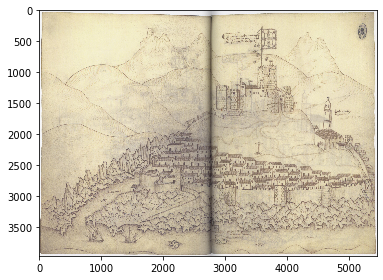

In [26]:
io.imshow(img);

### Read first from downloaded mask files, then URI

In [17]:
# for obj in ann['Label']['objects']:
obj = ann0['Label']['objects'][0]
mask_id = obj['featureId']
mask_path = os.path.join('.','Labelbox','masks',mask_id+'.png')

if os.path.exists(mask_path):
    img = io.imread(mask_path)
else:
    mask_img = io.imread(obj['instanceURI'])
    io.imsave(mask_path, mask_img)

In [18]:
mask_img[:,:,3]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

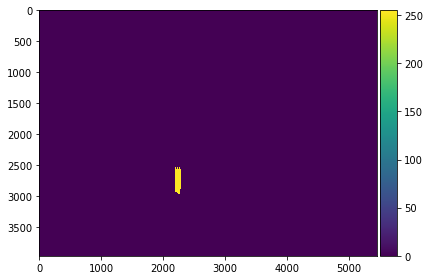

In [20]:
io.imshow(mask_img[:,:,3]);

### Do masking for whole image to test

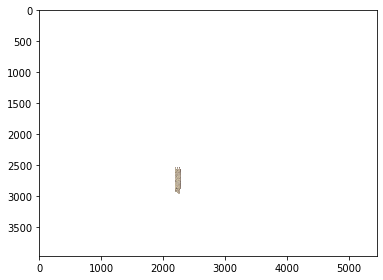

In [28]:
img_masked = np.zeros((img.shape[0], img.shape[1], 4),dtype=np.uint8)
img_masked[:,:,:3] = img[:,:,:3]
img_masked[:,:,3] = mask_img[:,:,3]
io.imshow(img_masked);

### Finding mask bounds

If we find the mask bounding box we can use it to crop everything and never created a full-sized masked image. Tested this np.any() method against np.argwhere() method, and it is indeed much faster

https://stackoverflow.com/questions/4808221/is-there-a-bounding-box-function-slice-with-non-zero-values-for-a-ndarray-in

```
%timeit bbox2(mask00[:,:,3])
26.7 ms ± 350 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
```

In [29]:
def bbox2(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    return (rmin,rmax+1), (cmin,cmax+1)

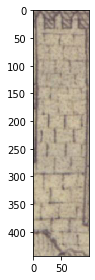

In [32]:
(rmin,rmax),(cmin,cmax) = bbox2(mask_img[:,:,3])
io.imshow(img[rmin:rmax,cmin:cmax,:]);

### Mask boundaries okay

Checked to make sure there weren't any off-by-one errors on any of the mask boundaries for where the slice gets applied.

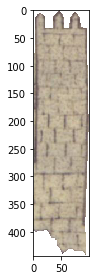

In [33]:
(rmin,rmax),(cmin,cmax) = bbox2(mask_img[:,:,3])
img_masked = np.zeros((rmax-rmin,cmax-cmin,4), dtype=np.uint8)
img_masked[:,:,:3] = img[slice(rmin,rmax), slice(cmin,cmax), :3]
img_masked[:,:,3] = mask_img[slice(rmin,rmax), slice(cmin,cmax), 3]
io.imshow(img_masked);

In [34]:
masked_img_path = os.path.join('.','Labelbox','masked_features',mask_id+'.png')
io.imsave(masked_img_path, img_masked)

---

## Move mask images 

and masked PNGs into subdirectories according to source image

---

## Bitmaps to polygons

https://stackoverflow.com/questions/58340068/fully-convert-a-black-and-white-image-to-a-set-of-lines-aka-vectorize-using-onl
